## Урок 7. Кейс 2. Типы моделей для задачи тарификации

### Домашнее задание (часть 2)

In [29]:
%matplotlib inline

import pandas as pd
import xgboost as xgb
import warnings

from sklift.models import ClassTransformation
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, uplift_auc_score
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [30]:
warnings.simplefilter('ignore')

#### 1. Придумать новые признаки (у нас их всего 5 было) - сделать дополнительный feature engineering

In [31]:
# Чтение данных
df_clients = pd.read_csv('./data/clients.csv', index_col='client_id')
df_train = pd.read_csv('./data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('./data/uplift_test.csv', index_col='client_id')

In [32]:
# Обработка признаков
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400162 entries, 000012768d to fffff6ce77
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   first_issue_date   400162 non-null  object
 1   first_redeem_date  364693 non-null  object
 2   age                400162 non-null  int64 
 3   gender             400162 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


In [33]:
df_clients['age'].describe()

count    400162.000000
mean         46.488112
std          43.871218
min       -7491.000000
25%          34.000000
50%          45.000000
75%          59.000000
max        1901.000000
Name: age, dtype: float64

In [34]:
ind = (df_clients['age'] <= 120) & (df_clients['age'] >= 0)
df_test = df_test[ind]
df_train = df_train[ind]
df_clients = df_clients[ind]

df_clients['age'].describe()

count    399849.000000
mean         46.505698
std          16.238195
min           0.000000
25%          34.000000
50%          45.000000
75%          59.000000
max         119.000000
Name: age, dtype: float64

In [35]:
df_clients

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U
...,...,...,...,...
fffece623e,2018-05-13 15:09:30,2018-12-27 19:06:39,67,U
ffff3dfff8,2018-11-01 16:06:52,2018-12-07 17:33:47,56,F
ffffaab9da,2017-08-25 18:43:24,2017-12-08 17:53:19,23,F


In [36]:
df_clients['first_issue_date'] = pd.to_datetime(df_clients['first_issue_date'])
df_clients['first_redeem_date'] = pd.to_datetime(df_clients['first_redeem_date'])

In [37]:
def new_date_feature(df, field_date):
    df[field_date + 'year'] = df[field_date].dt.year
    df[field_date + 'month'] = df[field_date].dt.month
    df[field_date + 'dayofmonth'] = df[field_date].dt.day
    df[field_date + 'quarter'] = df[field_date].dt.quarter
    df[field_date + 'dayofyear'] = df[field_date].dt.dayofyear
    df[field_date + 'weekofyear'] = df[field_date].dt.weekofyear
    df[field_date + 'dayofweek'] = df[field_date].dt.dayofweek
    df[field_date + 'hour'] = df[field_date].dt.hour

In [38]:
new_date_feature(df_clients, 'first_issue_date')
new_date_feature(df_clients, 'first_redeem_date')

In [39]:
df_features = df_clients.copy()
df_features['first_issue_time'] = (df_features['first_issue_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = (df_features['first_redeem_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

In [40]:
df_features = pd.get_dummies(df_features, drop_first=True)
df_features = df_features.fillna(0)
df_features

,age,first_issue_dateyear,first_issue_datemonth,first_issue_datedayofmonth,first_issue_datequarter,first_issue_datedayofyear,first_issue_dateweekofyear,first_issue_datedayofweek,first_issue_datehour,first_redeem_dateyear,...,first_redeem_datequarter,first_redeem_datedayofyear,first_redeem_dateweekofyear,first_redeem_datedayofweek,first_redeem_datehour,first_issue_time,first_redeem_time,issue_redeem_delay,gender_M,gender_U
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,45,2017,8,5,3,217,31,5,15,2018.0,...,1.0,4.0,1.0,3.0,19.0,1501947648,1.515094e+09,13146559.0,0,1
000036f903,72,2017,4,10,2,100,15,0,13,2017.0,...,2.0,113.0,16.0,6.0,12.0,1491832463,1.492951e+09,1118613.0,0,0
000048b7a6,68,2018,12,15,4,349,50,5,13,0.0,...,0.0,0.0,0.0,0.0,0.0,1544880791,0.000000e+00,0.0,0,0
000073194a,60,2017,5,23,2,143,21,1,12,2017.0,...,4.0,328.0,47.0,4.0,11.0,1495544174,1.511522e+09,15978107.0,0,0
00007c7133,67,2017,5,22,2,142,21,0,16,2018.0,...,4.0,365.0,1.0,0.0,17.0,1495469828,1.546277e+09,50806825.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffece623e,67,2018,5,13,2,133,19,6,15,2018.0,...,4.0,361.0,52.0,3.0,19.0,1526224170,1.545938e+09,19713429.0,0,1
ffff3dfff8,56,2018,11,1,4,305,44,3,16,2018.0,...,4.0,341.0,49.0,4.0,17.0,1541088412,1.544204e+09,3115615.0,0,0
ffffaab9da,23,2017,8,25,3,237,34,4,18,2017.0,...,4.0,342.0,49.0,4.0,17.0,1503686604,1.512756e+09,9068995.0,0,0


In [41]:
df_train.head(3)

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1


In [42]:
df_train.groupby('treatment_flg')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,99969.0,0.603287,0.489218,0.0,0.0,1.0,1.0,1.0
1,99902.0,0.636564,0.480991,0.0,0.0,1.0,1.0,1.0


In [43]:
df_train['target'].value_counts()

1    123904
0     75967
Name: target, dtype: int64

In [44]:
# Разделение на test и train
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, 
                                                test_size=0.4, 
                                                random_state=12)

In [45]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'roc auc': [],
}

#### 2. Для подходов с одной моделью поварьировать параметры CatBoostClassifier либо даже попробовать другой алгоритм (опционально уже).

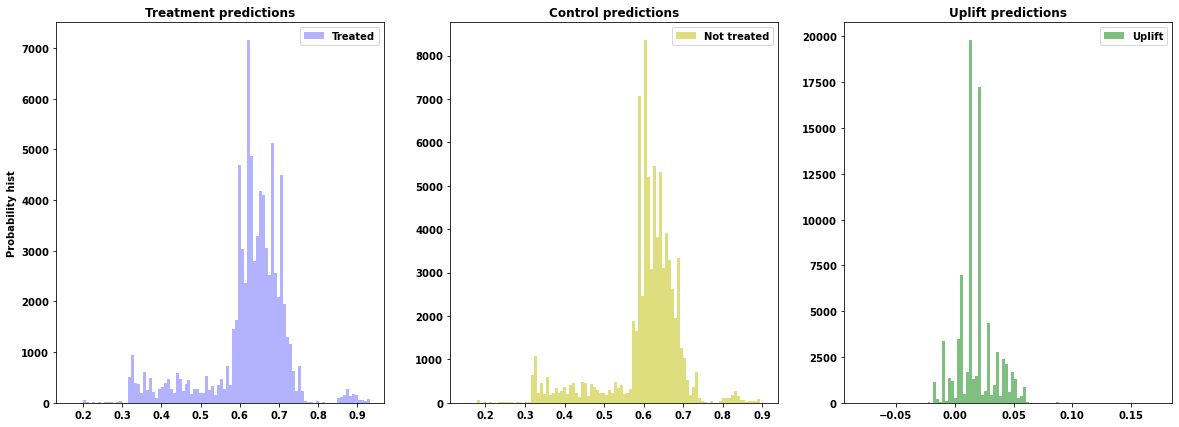

In [46]:
# Одна модель с признаком коммуникации
sm = SoloModel(xgb.XGBClassifier(n_estimators = 10, max_depth = 4, random_state=42))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [47]:
# Трансформация классов
ct = ClassTransformation(xgb.XGBClassifier(n_estimators = 100, max_depth = 1, random_state=42))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

#### 3. Для пункта 2 (подходов на основе одной модели) вывести значимость признаков, основываясь на model.estimator.feature_importances_ и model.estimator.feature_names_.

In [48]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.get_booster().feature_names,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_dateyear,0.819406
1,issue_redeem_delay,0.049292
2,first_redeem_time,0.040372
3,first_redeem_datehour,0.036149
4,treatment,0.012127
5,age,0.009944
6,gender_U,0.008645
7,first_issue_time,0.005370
8,first_redeem_datedayofmonth,0.004346
9,first_redeem_datedayofyear,0.003883


In [49]:
sm_fi = pd.DataFrame({
    'feature_name': ct.estimator.get_booster().feature_names,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_datedayofmonth,0.318008
1,first_redeem_time,0.197211
2,age,0.155035
3,first_issue_time,0.123110
4,issue_redeem_delay,0.116542
5,first_redeem_datedayofweek,0.090094
6,first_issue_datedayofmonth,0.000000
7,first_redeem_datedayofyear,0.000000
8,gender_M,0.000000
9,first_issue_datemonth,0.000000


#### 4. Дополнить models_results дополнительными метриками (roc auc, logloss, f1). В конце вывести сводную таблицу всех показателей для всех подходов (как на основе

In [52]:
models_results['roc auc'].append(uplift_auc_score(y_val, uplift_sm, treatment=treat_val))
models_results['roc auc'].append(uplift_auc_score(y_val, uplift_ct, treatment=treat_val))

In [54]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,roc auc
1,ClassTransformation,0.065999,0.029057
0,SoloModel,0.061674,0.026703
